In [1]:
import sys
sys.path.append('/home/yungdankblast/DelayedOptimization')
from FuncOptHandler import Handler
import numpy as np
from Optimizer_Scripts.DelayTypeGenerators import Undelayed, Uniform, Stochastic, Partial
from Optimizer_Scripts import learning_rate_generator as lr_gen
from Optimizer_Scripts.LossFunc import LossFunc
from Optimizer_Scripts.Data import Data
from matplotlib import pyplot as plt

In [119]:
def get_state_arr(data):    # 1D function only
    state_arr = np.empty([len(data.state_vals), data.maxiter+1])
    for j, state_vals in enumerate(data.state_vals):
        state_vals = state_vals.flatten()
        state_arr[j][:len(state_vals)] = state_vals
        state_arr[j][len(state_vals):] = state_vals[-1]
    return state_arr  

def plot_time_loss(undel_data, del_data, ylim=None, vlines=[], yscale=None, legend_loc="best"):
    undel_loss_arr = undel_data.get_loss_array()
    del_loss_arr = del_data.get_loss_array()
    plt.plot(undel_loss_arr.T, color="C0", alpha=1/255)
    plt.plot(del_loss_arr.T, color="C1", alpha=1/255)
    plt.plot(np.mean(undel_loss_arr, axis=0), label="Undelayed", color="C0")
    plt.plot(np.mean(del_loss_arr, axis=0), label="Delayed", color="C1")
    if ylim is not None:
        plt.ylim(ylim)
    for vline in vlines:
        plt.axvline(vline, color="black", linestyle="--")
    if yscale is not None:
        plt.yscale(yscale)

    plt.title("Mean Loss Over Time")
    plt.legend(loc=legend_loc)

def plot_time_state(undel_data, del_data):
    plt.plot(get_state_arr(undel_data).T, label="Undelayed", color="C0", alpha=0.01)
    plt.plot(get_state_arr(del_data).T, label="Delayed", color="C1", alpha=0.01)
    plt.title("State Values Over Time")

def plot_final_states(data, xlim=None):
    loss = data.get_loss_function()
    xlim = loss.domain if xlim is None else xlim
    x = np.linspace(*xlim, 100)
    y = [loss.loss(np.array([val])) for val in x]
    
    if data.delay_params['delay_type'].lower() == "undelayed":
        delay_str = "Undelayed"
    else:
        delay_str = "Delayed"

    plt.plot(x, y, label="Loss Function")
    plt.scatter(data.get_finals(data.state_vals), data.get_finals(data.loss_vals), label=f"{delay_str} Final States", color="red", alpha=0.01, zorder=10)
    plt.title(f"{delay_str} Final State Values")

# LR Schedulers (w/ stability params)

In [4]:
import math

def get_lr_condition(epsilon, delta=20/9):
    return math.sqrt(epsilon) * delta

## LR Scheduler plots

In [5]:
maxiter = 5000
epsilon = 1e-5

stable_lr = get_lr_condition(epsilon)
intr_stable_lr = get_lr_condition(epsilon, delta=2)

print("Stable LR:", stable_lr)
print("Intrinsically Stable LR:", intr_stable_lr)

Stable LR: 0.0070272836892630655
Intrinsically Stable LR: 0.006324555320336759


In [80]:
def inv_gamma_from_p(max_lr, min_lr, maxiter, p):
    return ((max_lr / min_lr)**(1/p) - 1) / maxiter

def get_inv_scheduler(max_lr, min_lr, maxiter, p):
    gamma = inv_gamma_from_p(max_lr, min_lr, maxiter, p)
    return lr_gen.inv(max_lr=max_lr, gamma=gamma, p=p)

def get_lr_seq(lr_scheduler, maxiter):
    return np.array([next(lr_scheduler) for _ in range(maxiter)])

def get_lr_idx_in_seq(lr_seq, lr):
    indices = np.nonzero(lr_seq < lr)[0]
    if len(indices) > 0:
        return indices[0]

def plot_lr_boundary(lr_seq, lr, color='C0'):
    idx = get_lr_idx_in_seq(lr_seq, lr)
    if idx is not None:
        return plt.axvline(idx, color=color, linestyle='--')

def plot_lr_scheduler(lr_scheduler, maxiter, color='C0'):
    lr_seq = get_lr_seq(lr_scheduler, maxiter)
    seq = plt.plot(lr_seq, color=color)
    stable_bound = plot_lr_boundary(lr_seq, stable_lr, color=color)
    intr_stable_bound = plot_lr_boundary(lr_seq, intr_stable_lr, color=color)
    return seq, stable_bound, intr_stable_bound

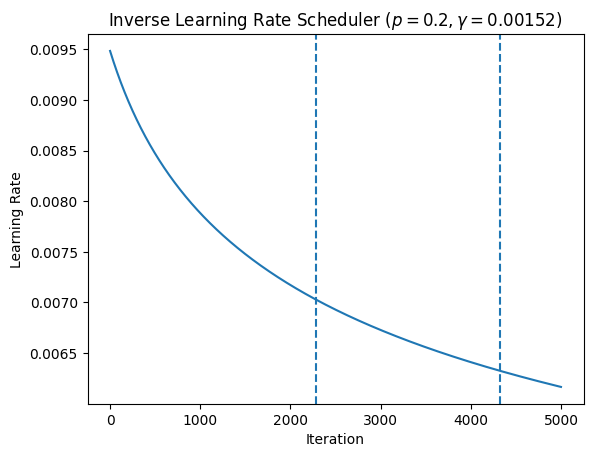

Max LR: 0.009486832980505138
Min LR: 0.006166441437328339


In [78]:
max_lr = get_lr_condition(epsilon, delta=3.)
min_lr = get_lr_condition(epsilon, delta=1.95)
p = .2

gamma = inv_gamma_from_p(max_lr, min_lr, maxiter, p=p)
inv = lr_gen.inv(max_lr=max_lr, gamma=gamma, p=p)
_, stable_bound, int_stable_bound = plot_lr_scheduler(inv, maxiter)
plt.title(r"Inverse Learning Rate Scheduler $(p={}, \gamma={})$".format(p, round(gamma,5)))
plt.xlabel("Iteration")
plt.ylabel("Learning Rate")
plt.show()

print("Max LR:", max_lr)
print("Min LR:", min_lr)

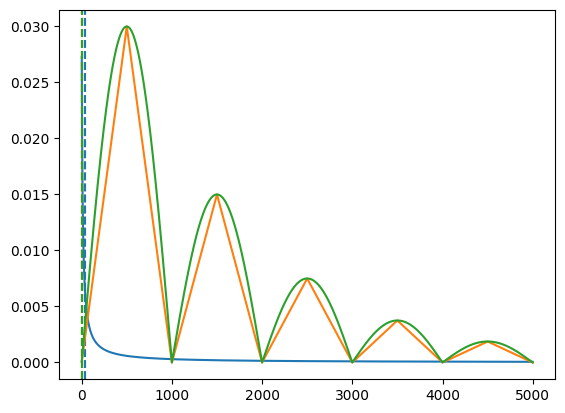

In [82]:
small_lr = .03

plot_lr_scheduler(lr_gen.inv(max_lr=small_lr, gamma=.1, p=1), maxiter, color='C0')
plot_lr_scheduler(lr_gen.tri_2(max_lr=small_lr, min_lr=0, step_size=500), maxiter, color='C1')
plot_lr_scheduler(lr_gen.sin_2(max_lr=small_lr, min_lr=0, step_size=500), maxiter, color='C2')
plt.show()

# Pre-Computed Results

## Const Results

#### Global

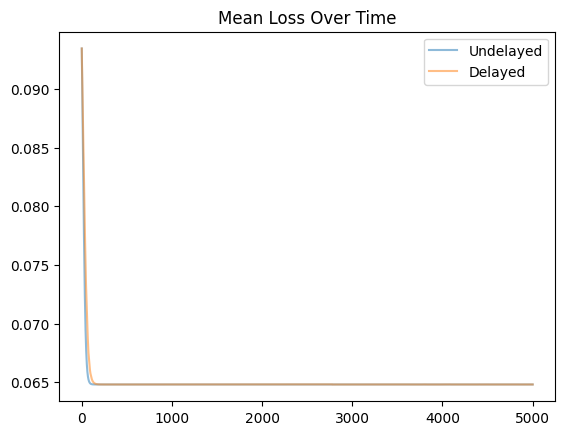

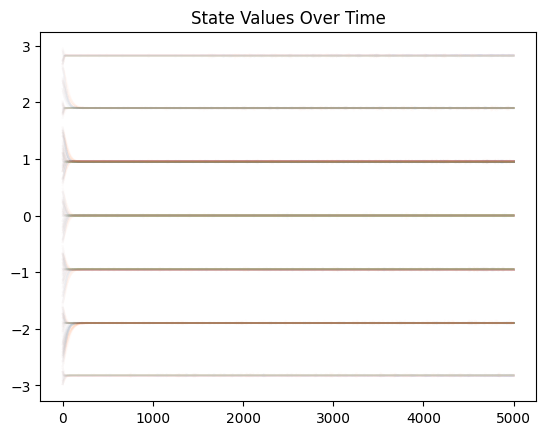

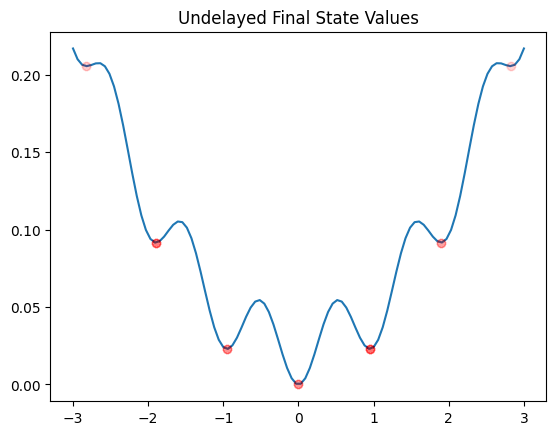

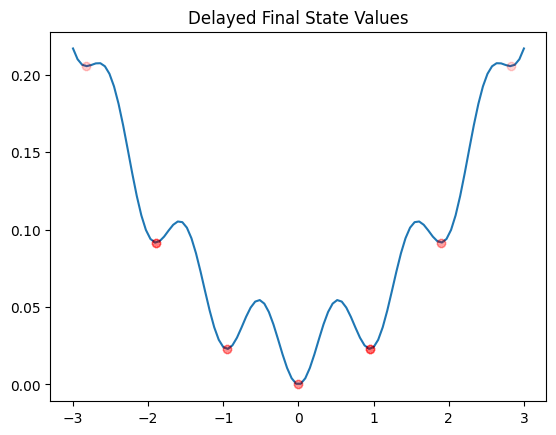

In [10]:
undel_data = Data.load("Data/stable1d_undel_const_stable.dat")
del_data = Data.load("Data/stable1d_stochL1_const_stable.dat")
xlim = [-3, 3]

plot_time_loss(undel_data, del_data)
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)

#### Local

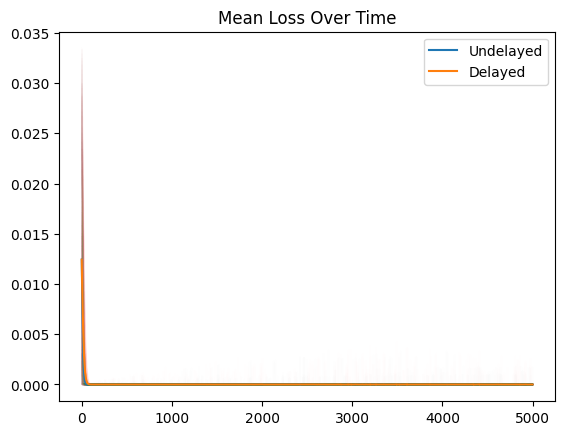

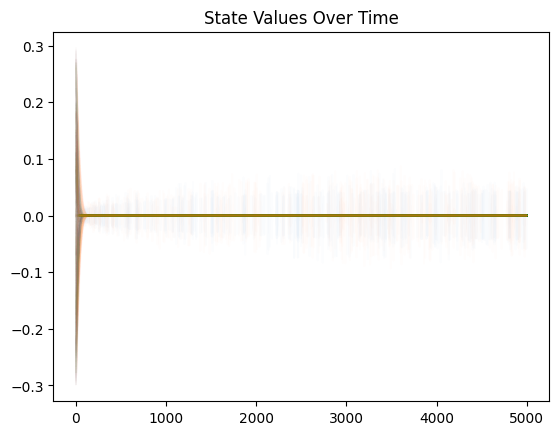

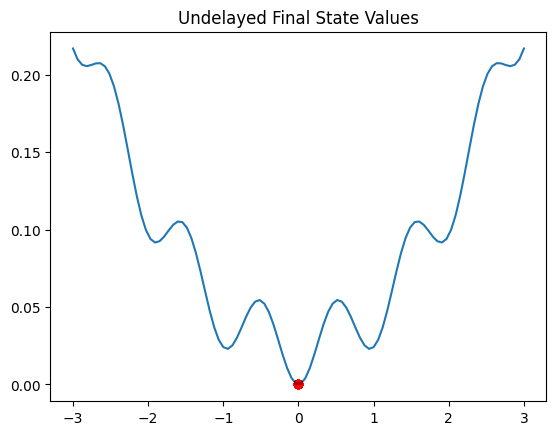

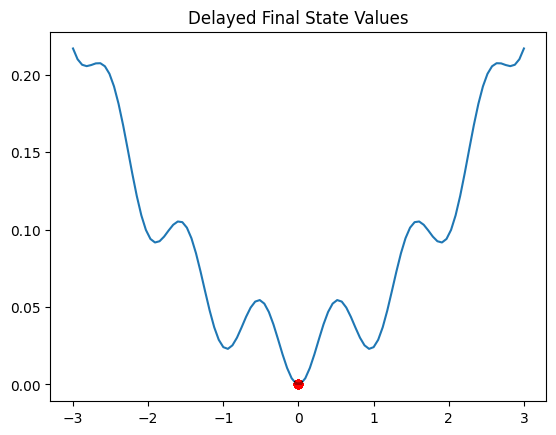

In [14]:
undel_data = Data.load("../data/stable1d_undel_const_small_local.dat")
del_data = Data.load("../data/stable1d_stochL1_const_small_local.dat")
xlim = [-3, 3]

plot_time_loss(undel_data, del_data)
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)

## Inv Results

### Global

#### Large starting LR

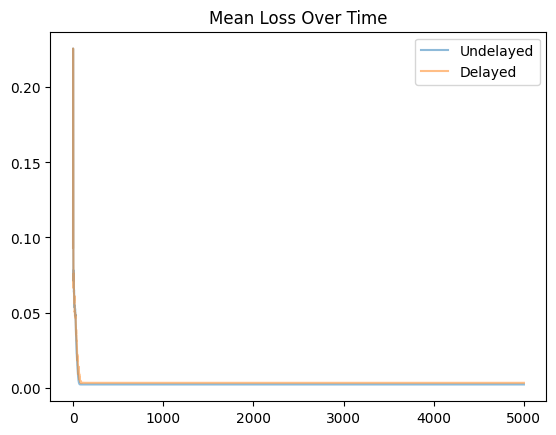

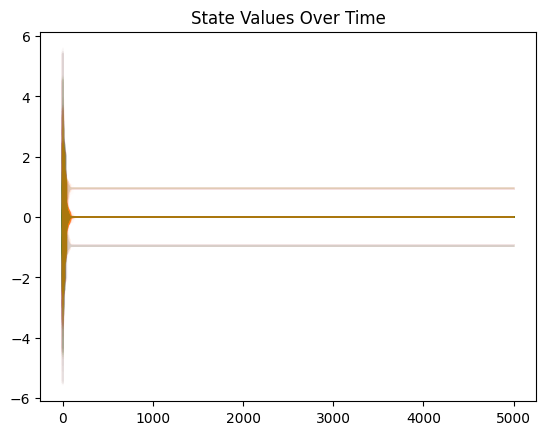

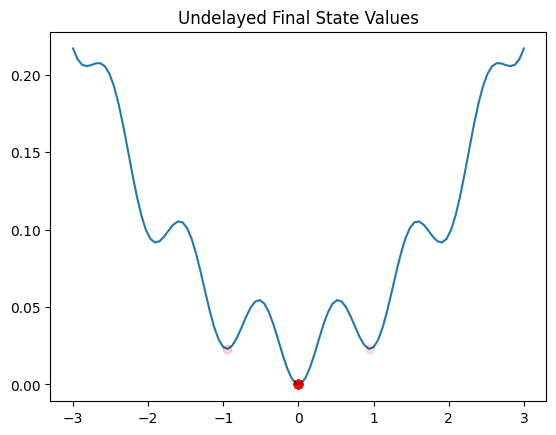

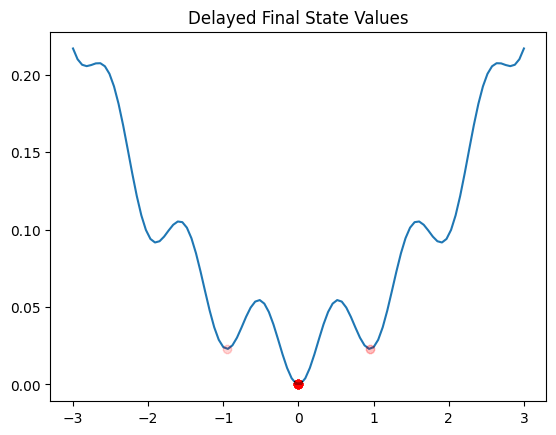

In [7]:
undel_data = Data.load("Data/stable1d_undel_inv_large.dat")
del_data = Data.load("Data/stable1d_stochL1_inv_large.dat")
xlim = [-3, 3]

plot_time_loss(undel_data, del_data)
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)

#### Small starting LR

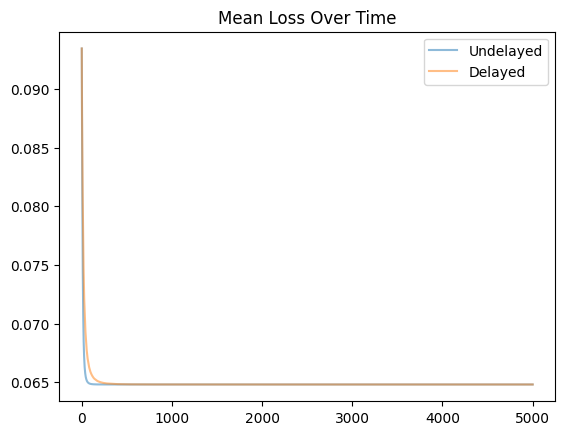

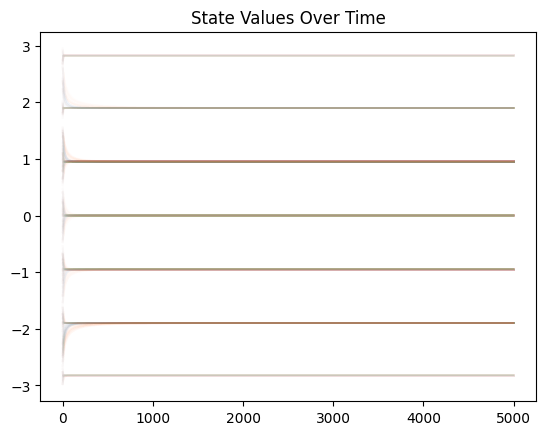

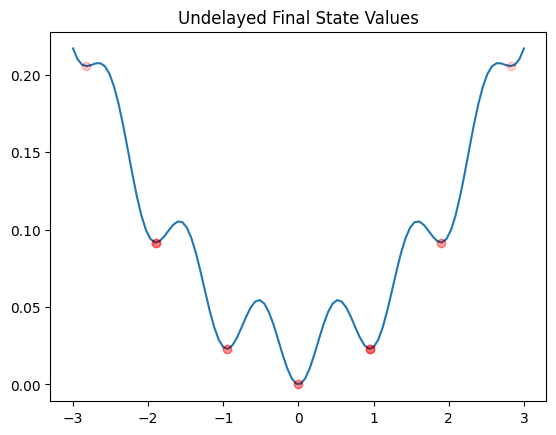

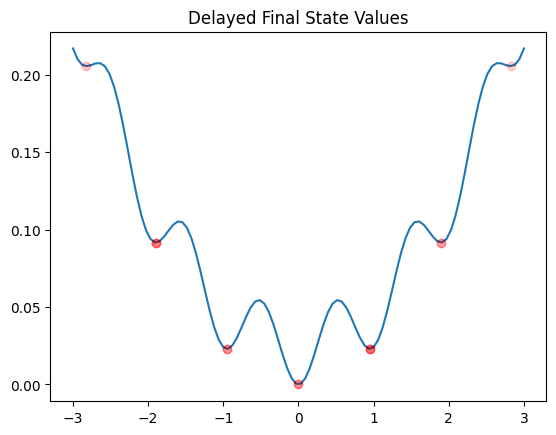

In [11]:
undel_data = Data.load("Data/stable1d_undel_inv_small.dat")
del_data = Data.load("Data/stable1d_stochL1_inv_small.dat")
xlim = [-3, 3]

plot_time_loss(undel_data, del_data)
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)

### Local

#### Large starting LR

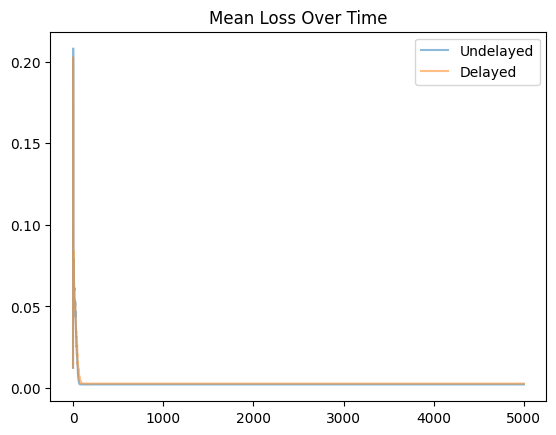

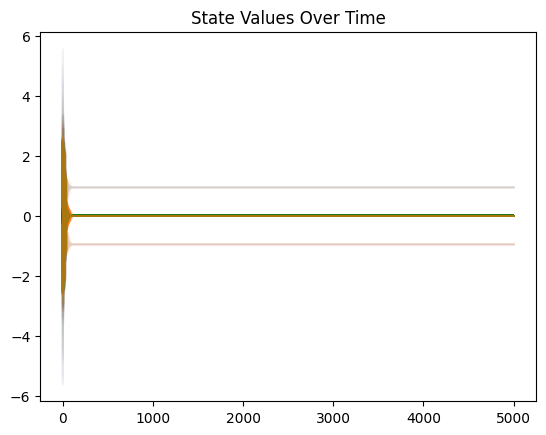

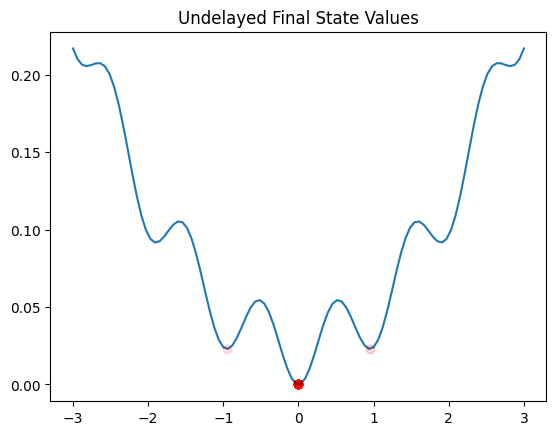

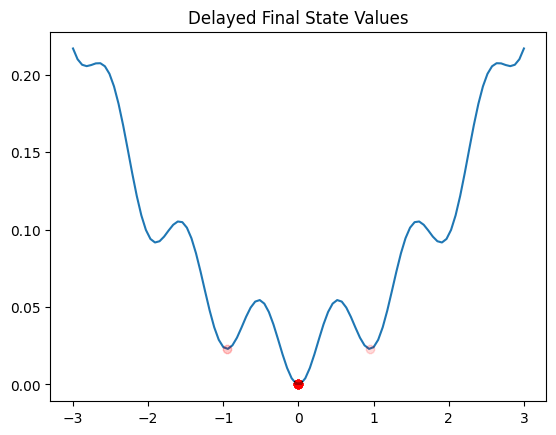

In [21]:
undel_data = Data.load("Data/stable1d_undel_inv_large_local.dat")
del_data = Data.load("Data/stable1d_stochL1_inv_large_local.dat")
xlim = [-3, 3]

plot_time_loss(undel_data, del_data)
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)

#### Small starting LR

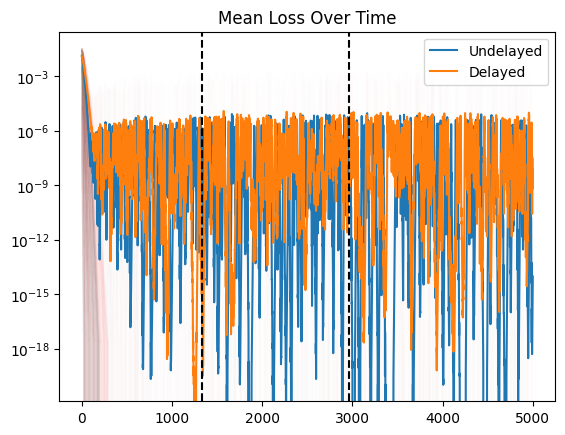

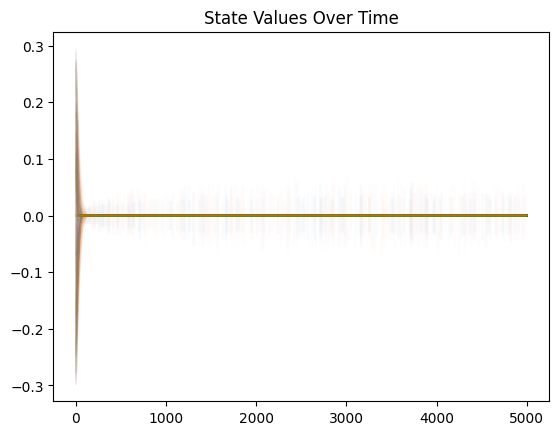

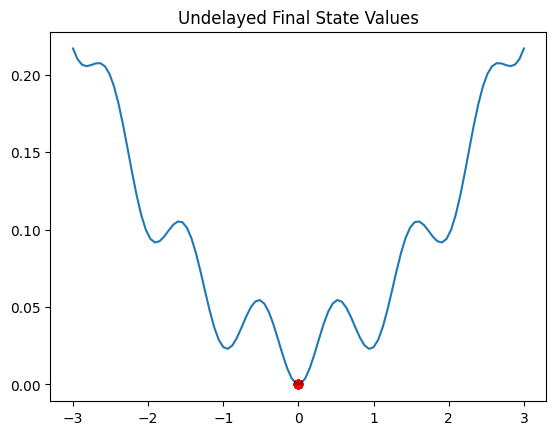

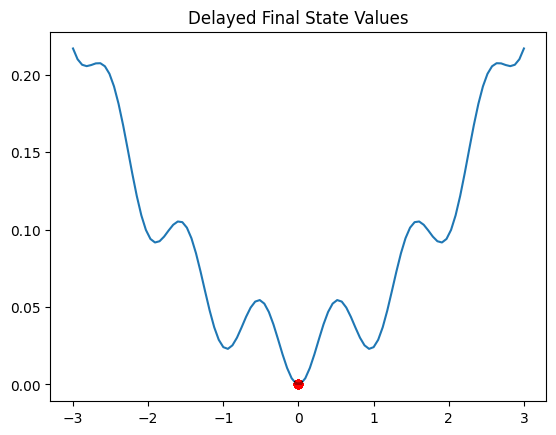

In [12]:
undel_data = Data.load("../data/stable1d_undel_inv_small_local.dat")
del_data = Data.load("../data/stable1d_stochL1_inv_small_local.dat")
xlim = [-3, 3]

plot_time_loss(undel_data, del_data, vlines=small_lr_idx, yscale="log", legend_loc="upper right")
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)

## Tri-2 Results

### Global

#### Large starting LR

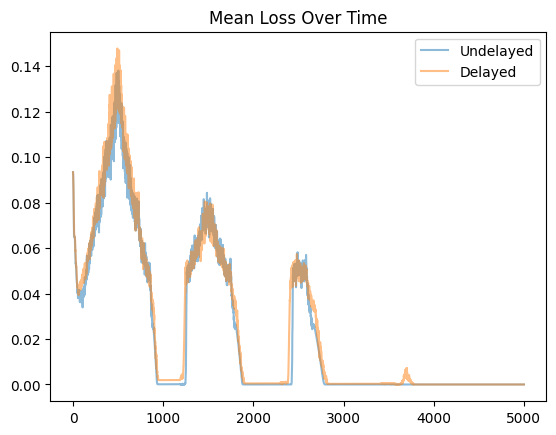

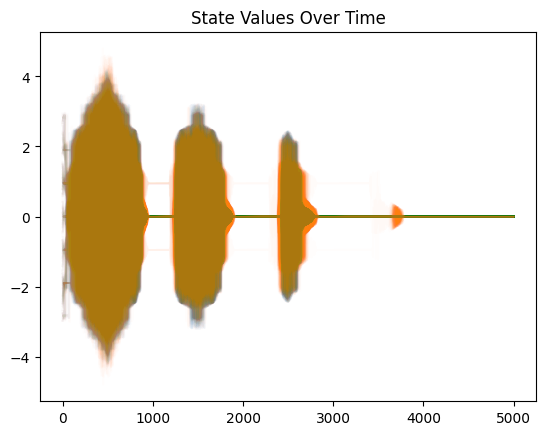

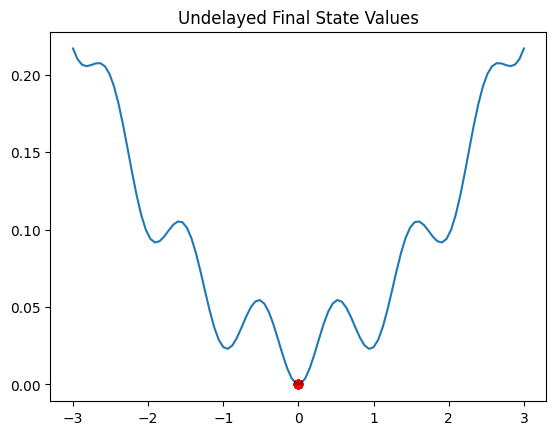

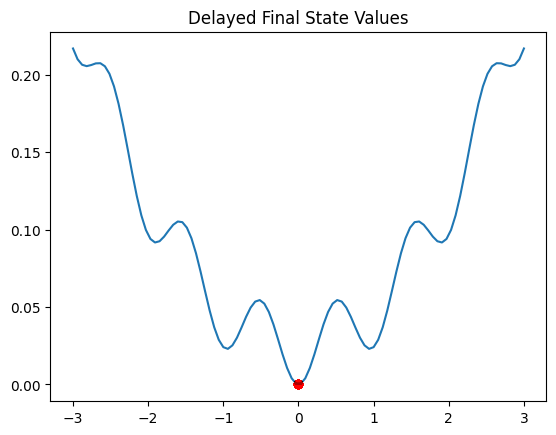

In [16]:
undel_data = Data.load("Data/stable1d_undel_tri2_large.dat")
del_data = Data.load("Data/stable1d_stochL1_tri2_large.dat")
xlim = [-3, 3]

plot_time_loss(undel_data, del_data)
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)

#### Small starting LR

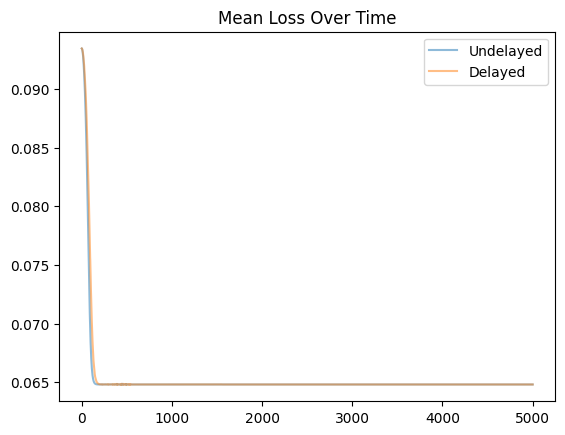

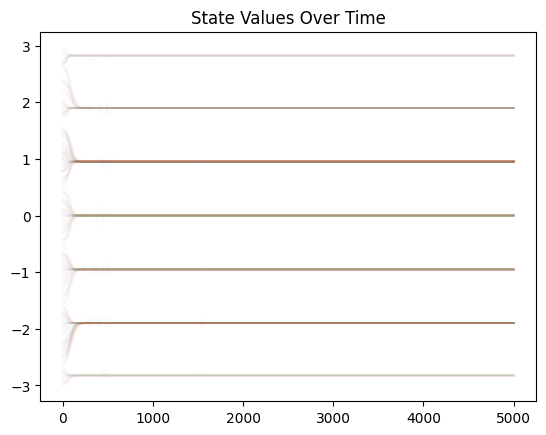

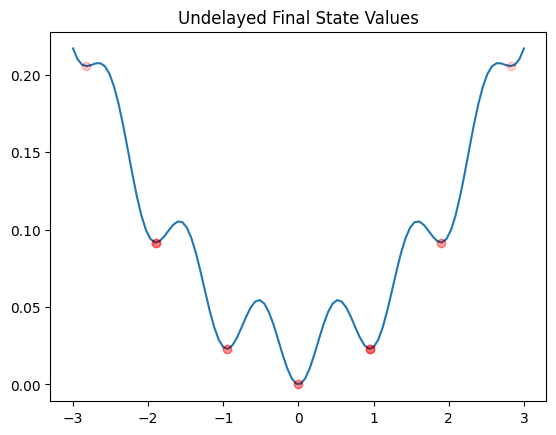

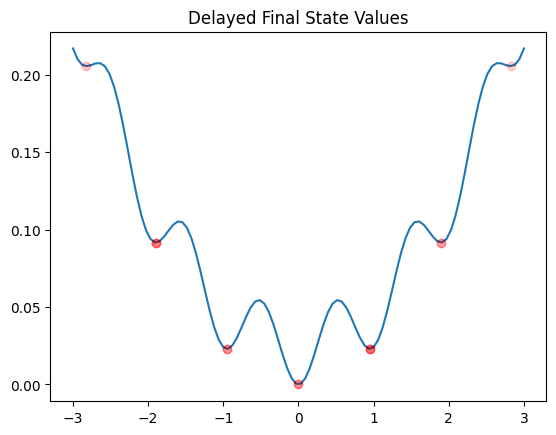

In [17]:
undel_data = Data.load("Data/stable1d_undel_tri2_small.dat")
del_data = Data.load("Data/stable1d_stochL1_tri2_small.dat")
xlim = [-3, 3]

plot_time_loss(undel_data, del_data)
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)

### Local

#### Large starting LR

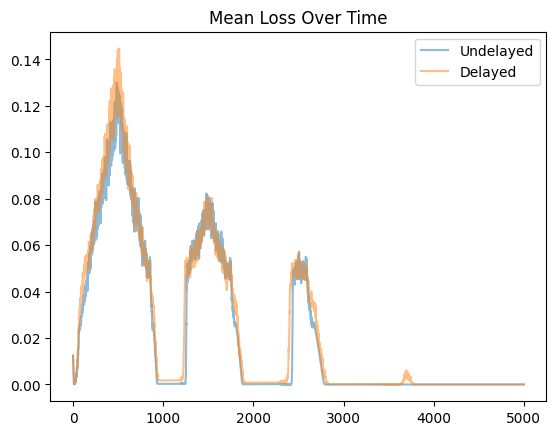

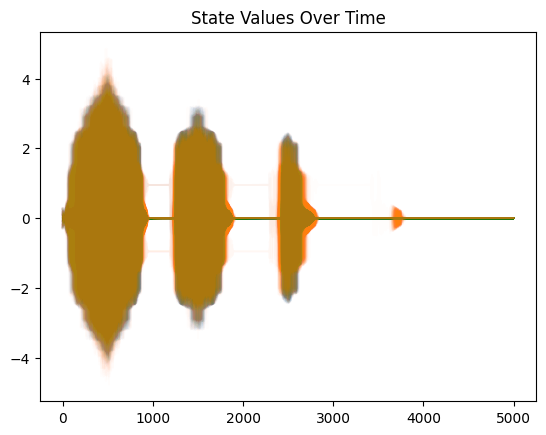

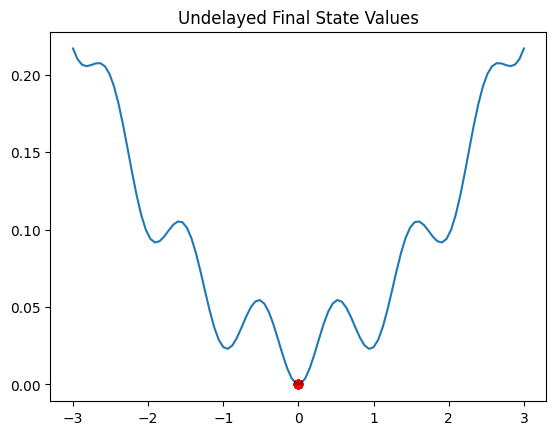

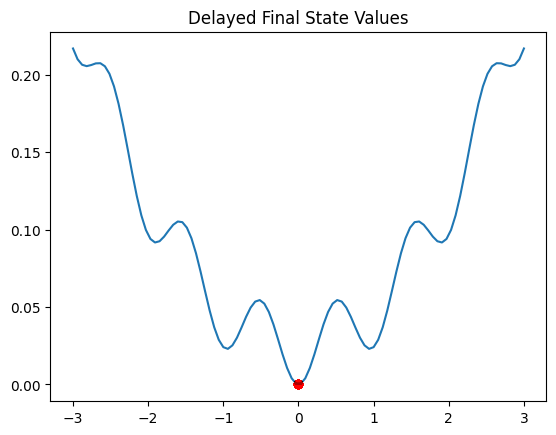

In [23]:
undel_data = Data.load("Data/stable1d_undel_tri2_large_local.dat")
del_data = Data.load("Data/stable1d_stochL1_tri2_large_local.dat")
xlim = [-3, 3]

plot_time_loss(undel_data, del_data)
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)

#### Small starting LR

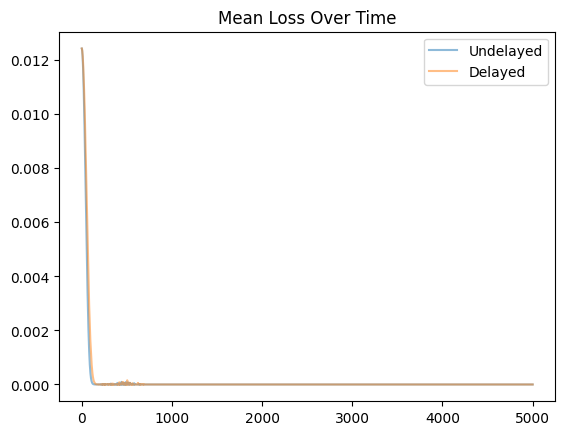

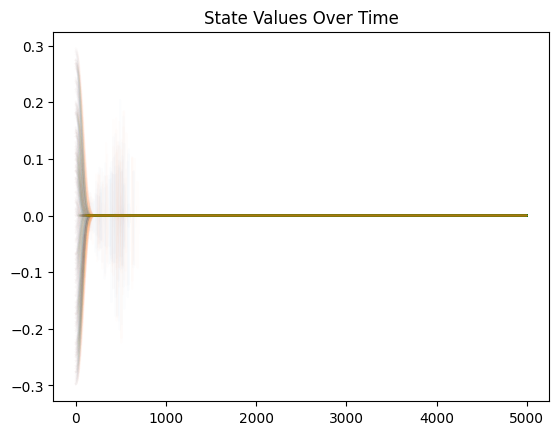

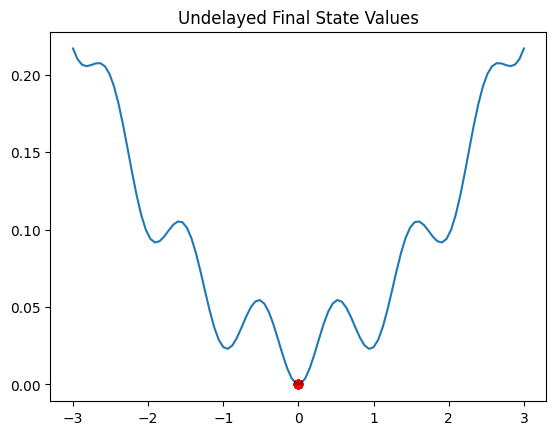

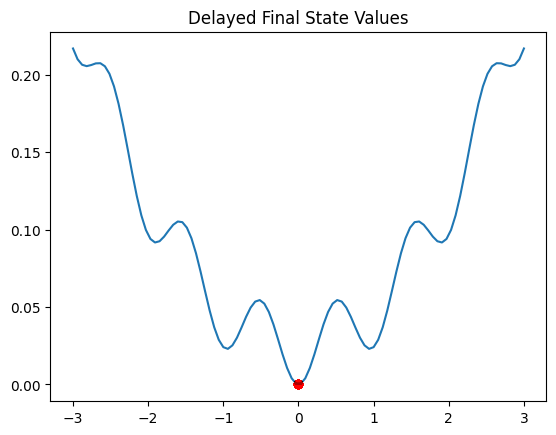

In [24]:
undel_data = Data.load("Data/stable1d_undel_tri2_small_local.dat")
del_data = Data.load("Data/stable1d_stochL1_tri2_small_local.dat")
xlim = [-3, 3]

plot_time_loss(undel_data, del_data)
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)

## Sin-2 Results

### Global

#### Large starting LR

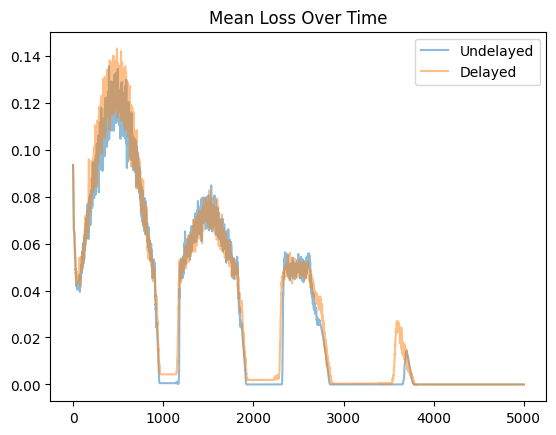

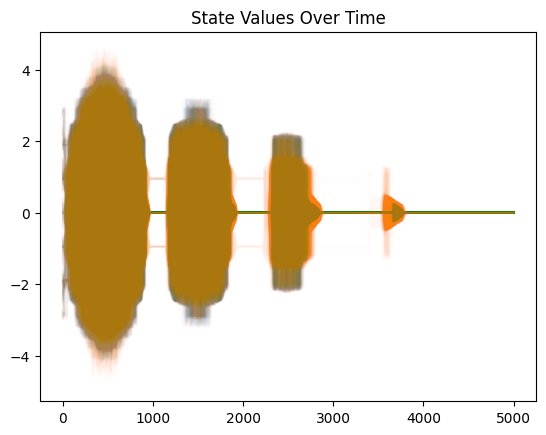

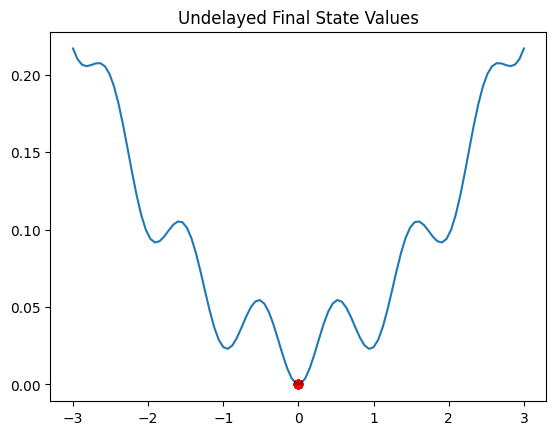

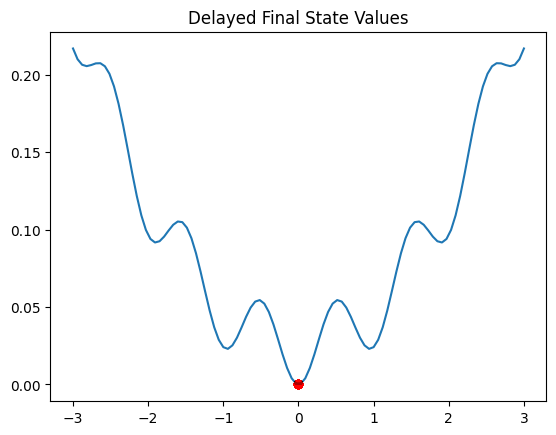

In [19]:
undel_data = Data.load("Data/stable1d_undel_sin2_large.dat")
del_data = Data.load("Data/stable1d_stochL1_sin2_large.dat")
xlim = [-3, 3]

plot_time_loss(undel_data, del_data)
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)

#### Small starting LR

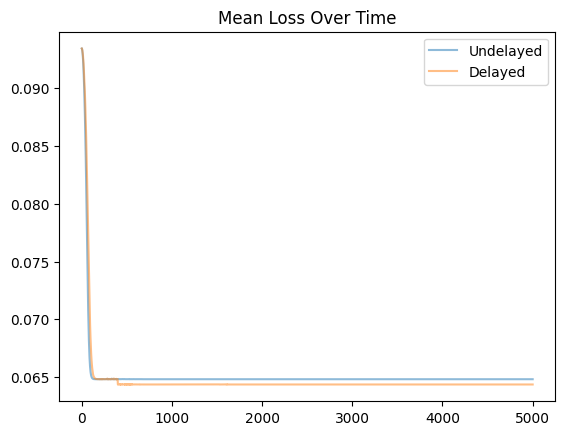

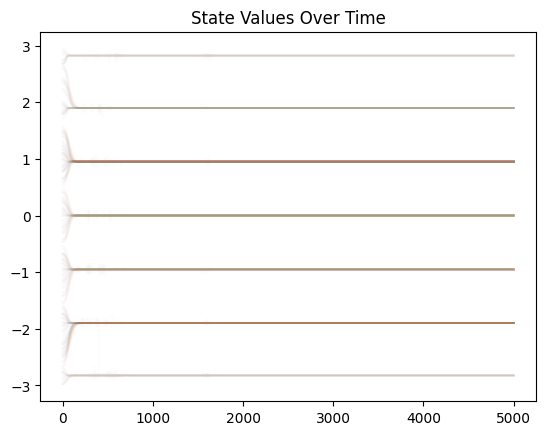

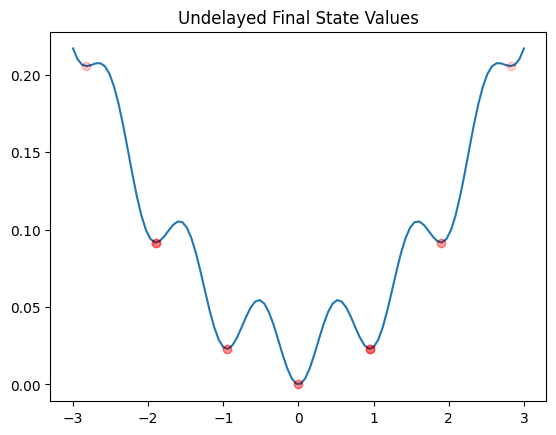

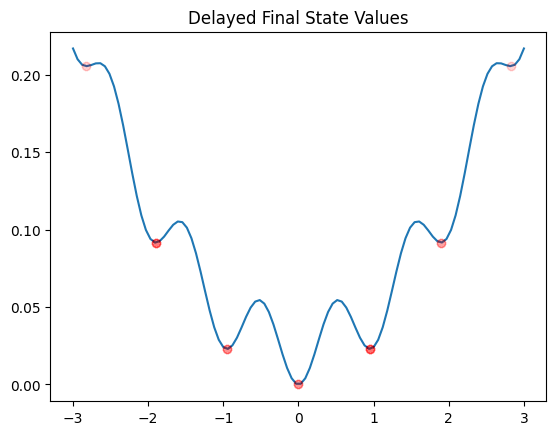

In [18]:
undel_data = Data.load("Data/stable1d_undel_sin2_small.dat")
del_data = Data.load("Data/stable1d_stochL1_sin2_small.dat")
xlim = [-3, 3]

plot_time_loss(undel_data, del_data)
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)

### Local

#### Large starting LR

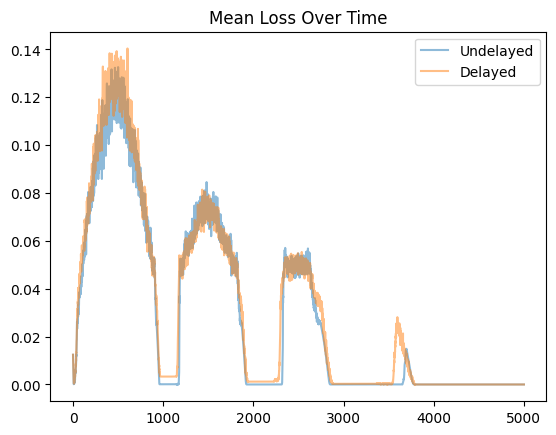

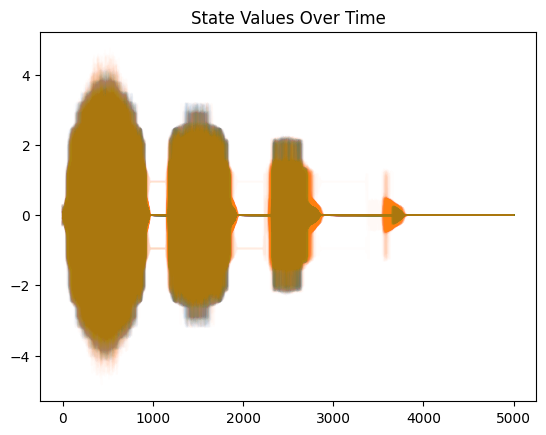

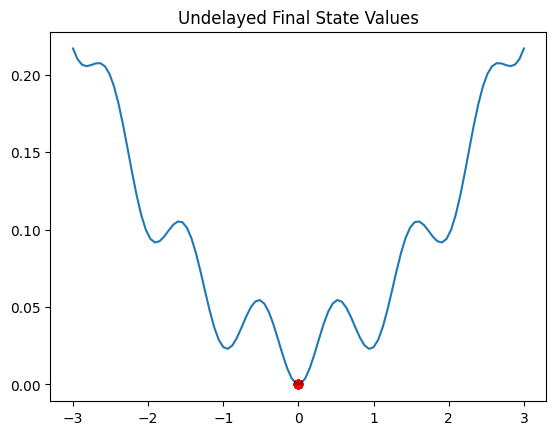

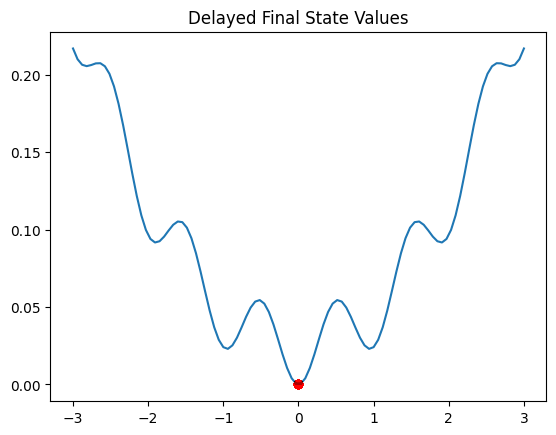

In [25]:
undel_data = Data.load("Data/stable1d_undel_sin2_large_local.dat")
del_data = Data.load("Data/stable1d_stochL1_sin2_large_local.dat")
xlim = [-3, 3]

plot_time_loss(undel_data, del_data)
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)

#### Small starting LR

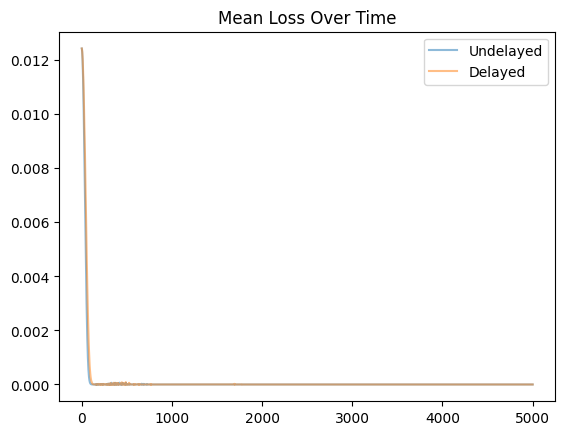

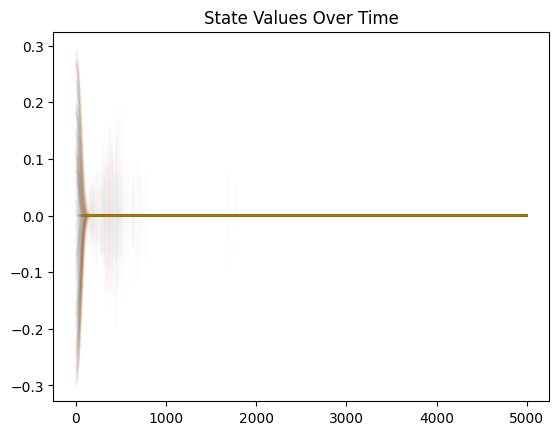

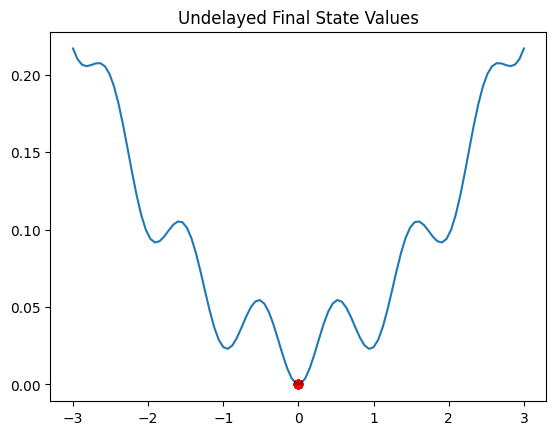

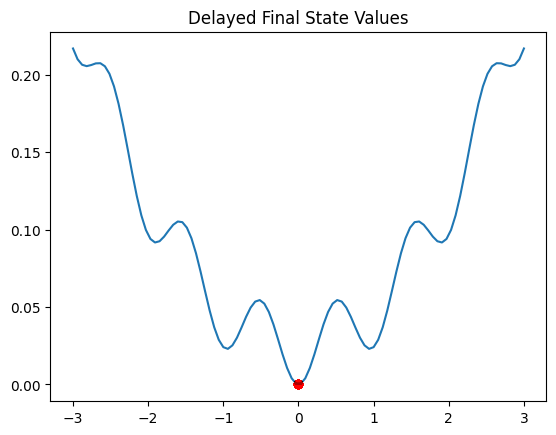

In [26]:
undel_data = Data.load("Data/stable1d_undel_sin2_small_local.dat")
del_data = Data.load("Data/stable1d_stochL1_sin2_small_local.dat")
xlim = [-3, 3]

plot_time_loss(undel_data, del_data)
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)

# Stable LR Testing

In [83]:
stable_handler = Handler("stable", 1)
stable_handler.load_points(np.array([[.3]]))

In [86]:
lr_params = {
    "lr_type": "inv",
    "max_lr": .00949,
    "gamma": .00152,
    "p": .2
}

In [124]:
def run_plot(lr_params, maxiter=5000, tol=1e-5, beta_1=0.9, ylim=None, logscale=False):
    params = {
        "beta_1": 0.25,
        "maxiter": maxiter,
        "tol": tol,
        "break_opt": False,   
    }
    undel_data = stable_handler.optimize(
        delay_type = Undelayed(), 
        **lr_params,
        **params,
    )
    del_data = stable_handler.optimize(
        delay_type = Stochastic(max_L=1, num_delays=maxiter),  
        **lr_params,
        **params,
    )
    plot_time_loss(undel_data, del_data, ylim=ylim, yscale="log" if logscale else None)
    lr_seq = get_lr_seq(lr_gen.generate_learning_rates(**lr_params), maxiter)
    plot_lr_boundary(lr_seq, stable_lr, color="black")
    plot_lr_boundary(lr_seq, intr_stable_lr, color="black")

stable 1d (stochastic): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


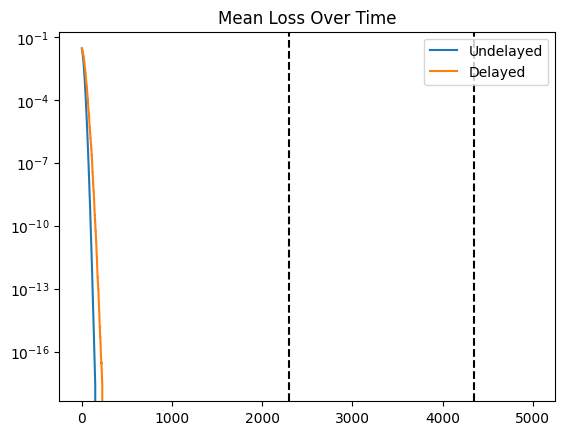

In [129]:
# stable_handler.load_points(np.random.uniform(-3, 3, (1,1)))
run_plot(lr_params, logscale=True)

stable 1d (stochastic): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


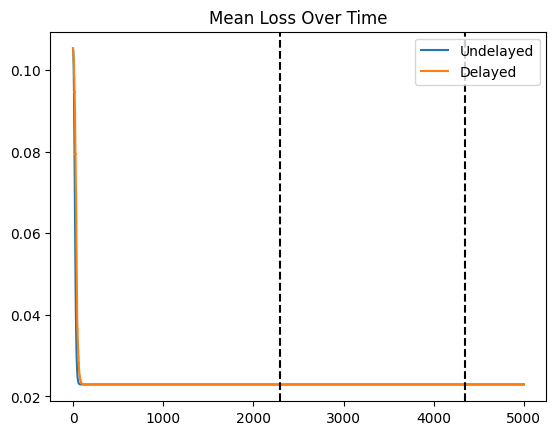

In [127]:
# stable_handler.load_points(np.random.uniform(-3, 3, (1,1)))
run_plot(lr_params, logscale=False)

stable 1d (stochastic): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


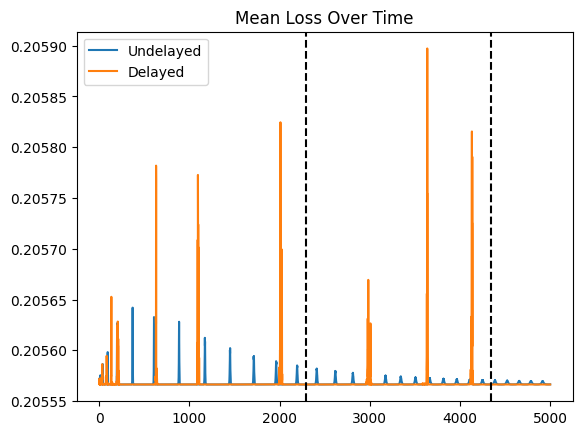

In [143]:
# stable_handler.load_points(np.random.uniform(-3, 3, (1,1)))
run_plot(lr_params, logscale=False)

In [144]:
stable_handler.x_inits

array([[-2.82682612]])